<a href="https://colab.research.google.com/github/rhiga2/DeepLearningHawaii/blob/main/workshops/pytorch_lightning_intro/PytorchLightningIntro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Lightning Introduction


In [1]:
!pip install torch
!pip install matplotlib
!pip install pytorch_lightning
!pip install torchvision
!pip install torchinfo
!pip install torchmetrics
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 KB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 32.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 27.7 MB

In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torchmetrics import Accuracy
import time
import pytorch_lightning as pl

## Pytorch Performance

In [3]:
def time_function(function, *args):
  start = time.time()
  output = function(*args)
  end = time.time()
  return output, end - start

In [4]:
# initialize data
a = torch.rand((20, 20))
b = torch.rand((20, 20))

In [5]:
# my own matrix multiplication implementation 
def my_mm(a, b):
  c = torch.zeros(a.size(0), b.size(1))
  for i in range(a.size(0)):
    for j in range(a.size(1)):
      for k in range(b.size(1)):
        c[i, k] += a[i, j] * b[j, k]
  return c 

my_output, my_duration = time_function(my_mm, a, b)
print("Time for custom matrix multiplication: ", my_duration)

Time for custom matrix multiplication:  0.18335795402526855


In [6]:
# matrix multiplication in pytorch 
def torch_mm(a, b):
  # write matrix multiplication in pytorch
  return a @ b

torch_output, torch_duration = time_function(torch_mm, a, b)
print("Square error between torch and my output: ", torch.sum((my_output - torch_output)**2).item())
print("Time for torch's matrix multiplication: ", torch_duration)
print("How much faster is pytorch: ", my_duration / torch_duration)

Square error between torch and my output:  2.2396307031158358e-11
Time for torch's matrix multiplication:  0.024596452713012695
How much faster is pytorch:  7.454650317452624


What can time difference be attributed to?
* Vectorized batch processing in pytorch implementation, better usage of memory and CPU
* Better algorithms for matrix multiplication
* Low-level optimizations in pytorch

## Weights and Biases

In [14]:
from pytorch_lightning.loggers import WandbLogger
%env WANDB_NOTEBOOK_NAME='PytorchLightningIntro.ipynb'

logger = WandbLogger(project='mnist_classifier')

env: WANDB_NOTEBOOK_NAME='PytorchLightningIntro.ipynb'


## Image Classification in Pytorch Lightning

What do you need to specify when training a pytorch lightning model?
* The dataset / dataloader
* The model
* The trainer 


### Load the Dataset

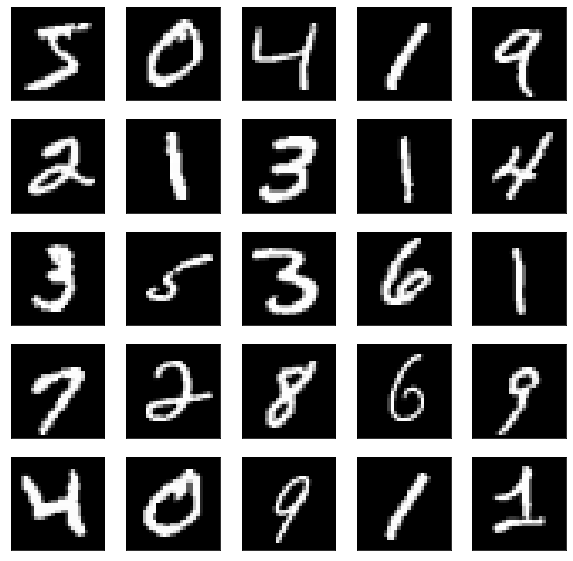

In [20]:
# Load the dataset
import torchvision

train_dataset = torchvision.datasets.MNIST(
    '/files/', train=True, download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]))

test_dataset = torchvision.datasets.MNIST(
    '/files/', train=False, download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]))

fig, ax = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
  for j in range(5):
    ax[i, j].grid(False)
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])
    ax[i, j].imshow(train_dataset[5*i+j][0].squeeze(0), cmap='gray')

In [9]:
# Create dataloaders
from torch.utils.data.sampler import SubsetRandomSampler

batch_size = 32
val_proportion = 0.2

# Split train set into train and validation
total_size = len(train_dataset)
indices = list(range(total_size))
val_size = int(total_size * val_proportion)
train_sampler = SubsetRandomSampler(indices[val_size:])
val_sampler = SubsetRandomSampler(indices[:val_size])

trainloader = torch.utils.data.DataLoader(train_dataset, 
                                          batch_size=batch_size,
                                          sampler=train_sampler)

valloader = torch.utils.data.DataLoader(train_dataset, 
                                        batch_size=batch_size,
                                        sampler=val_sampler)

testloader = torch.utils.data.DataLoader(train_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True)


### Specify the Model
Description of model:
* Input: (batch_size, 1, 28, 28)
* 1st 3x3 Convolution w/ 32 units
* 2nd 3x3 Convolution w/ 64 units
* 2x2 Max Pool
* 1st Dropout 25%
* Flatten
* 1st Dense + ReLU w/ 128 units
* 2nd Dropout 50%
* 2nd Dense w/ 10 units

In [10]:
# Conv net
accuracy = Accuracy('multiclass', num_classes=10).to(
    'cuda' if torch.cuda.is_available() else 'cpu'
)

class MnistClassifier(pl.LightningModule):
  def __init__(self):
    super().__init__()
    network = []
    
    # 1st 3x3 Convolution + ReLU w/ 32 units
    network.append(nn.Conv2d(1, 32, (3, 3), padding=1))
    network.append(nn.ReLU())
    
    # 2nd 3x3 Convolution + ReLU w/ 64 units
    network.append(nn.Conv2d(32, 64, (3, 3), padding=1))
    network.append(nn.ReLU())
    
    # 2x2 Max Pool
    network.append(nn.MaxPool2d((2, 2), 2))
    
    # 1st Dropout 25%
    network.append(nn.Dropout(0.25)) 

    # Flatten
    network.append(nn.Flatten())

    # 1st Dense + ReLU w/ 128 units
    network.append(nn.Linear(12544, 128))
    network.append(nn.ReLU())

    # 2nd Dropout 50%
    network.append(nn.Dropout(0.5))

    # 2nd Dense w/ 10 units
    network.append(nn.Linear(128, 10))
    self.network = nn.Sequential(*network)

  def forward(self, x):
    return self.network(x)

  def training_step(self, batch, batch_idx):
    x, y = batch
    logits = self(x)
    loss, acc = self._get_loss_and_accuracy(logits, y)
    self.log('training loss', loss)
    self.log("training accuracy", acc, prog_bar=True, on_step=False, 
             on_epoch=True)
    return loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    logits = self(x)
    loss, acc = self._get_loss_and_accuracy(logits, y)
    self.log('validation loss', loss)
    self.log("validation accuracy", acc)
    return loss, acc

  def test_step(self, batch, batch_idx):
    x, y = batch
    logits = self(x)
    loss, acc = self._get_loss_and_accuracy(logits, y)
    self.log('test loss', loss)
    self.log('test accuracy', acc)
    return loss, acc

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr = 1e-4)
    return optimizer

  def _get_loss_and_accuracy(self, logits, y):
    loss = F.cross_entropy(logits, y)
    acc = accuracy(logits, y)
    return loss, acc

In [11]:
model = MnistClassifier()
summary(model, (32, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
MnistClassifier                          [32, 10]                  --
├─Sequential: 1-1                        [32, 10]                  --
│    └─Conv2d: 2-1                       [32, 32, 28, 28]          320
│    └─ReLU: 2-2                         [32, 32, 28, 28]          --
│    └─Conv2d: 2-3                       [32, 64, 28, 28]          18,496
│    └─ReLU: 2-4                         [32, 64, 28, 28]          --
│    └─MaxPool2d: 2-5                    [32, 64, 14, 14]          --
│    └─Dropout: 2-6                      [32, 64, 14, 14]          --
│    └─Flatten: 2-7                      [32, 12544]               --
│    └─Linear: 2-8                       [32, 128]                 1,605,760
│    └─ReLU: 2-9                         [32, 128]                 --
│    └─Dropout: 2-10                     [32, 128]                 --
│    └─Linear: 2-11                      [32, 10]                  1,290


### Create the Trainer

In [12]:
# Create the trainer
trainer = pl.Trainer(accelerator="cuda", max_epochs=4, logger=logger)
trainer.fit(model, train_dataloaders=trainloader, val_dataloaders=valloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params
---------------------------------------
0 | network | Sequential | 1.6 M 
---------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.503     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find 'mnist_classifier'.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.


In [13]:
trainer.test(model, dataloaders=testloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    avg test accuracy       0.9875666499137878
      test accuracy         0.9875666499137878
        test loss           0.04218421131372452
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test loss': 0.04218421131372452,
  'test accuracy': 0.9875666499137878,
  'avg test accuracy': 0.9875666499137878}]

Text(0, 0.5, 'Class Label')

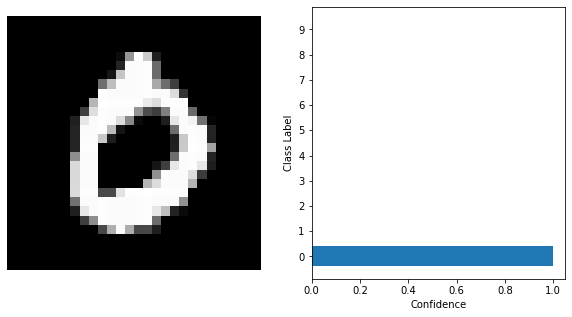

In [72]:
index = 3
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].axis('off')
image = test_dataset[index][0]
axs[0].imshow(image.squeeze(0), cmap='gray')

classes = torch.arange(10).detach().numpy()
axs[1].barh(classes, 
            F.softmax(model(image.unsqueeze(0)), dim=1).squeeze(0).detach().numpy())
axs[1].set_yticks(classes)
axs[1].set_xlabel('Confidence')
axs[1].set_ylabel('Class Label')